## In this notebook, we will
1. Import previously trained Linear, Ensemble and NN models to predict the reduction potential.
2. Compare the performance of these models on unseen datasets.Perform data cleaning operations (correlated feature elimination and p-value hypothesis testing) using customised classes and methods.
3. Report final performance metrics of these models.

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load testing data
Data was previously split into training and testing sets in <font color='blue'>1.MolRedPot_FeatureEngineering.ipynb</font>

In [2]:
features=pd.read_csv('Data/features_test_scaled.csv')
target=pd.read_csv('Data/target_test.csv')['ERed']

In [3]:
print('Feature matrix shape: ',features.shape)
print('Target property shape: ',target.shape)

Feature matrix shape:  (1089, 32)
Target property shape:  (1089,)


In [15]:
def test_plot(data,kind='scatter'):
    df_l=pd.DataFrame({'True':target,'Model':data})
    g=sns.jointplot(df_l,x='True',y='Model', kind=kind, color="#4CB391")
    g.fig.set_size_inches((4,4))
    llim,ulim=0.8,2
    plt.plot([llim,ulim],[llim,ulim],c='k',ls='--',alpha=0.3)
    plt.xlim([llim,ulim])
    plt.ylim([llim,ulim])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('True',fontsize=14)
    plt.ylabel('Model',fontsize=14)
    plt.text(1,1.9,'MAE = '+str(np.round(mean_absolute_error(target,data),5)*1000)+' meV')
    plt.text(1,1.8,'R$^2$ = '+str(np.round(r2_score(target,data),3)))
    plt.show()

## Load pre-trained linear model and test model on unseen data
The model was built and saved in <font color='blue'>2.MolRedPot_Regression.ipynb</font>

In [5]:
lr_model = pickle.load(open('Models/LinearRegression.sav', 'rb'))
t_linear=lr_model.predict(features)

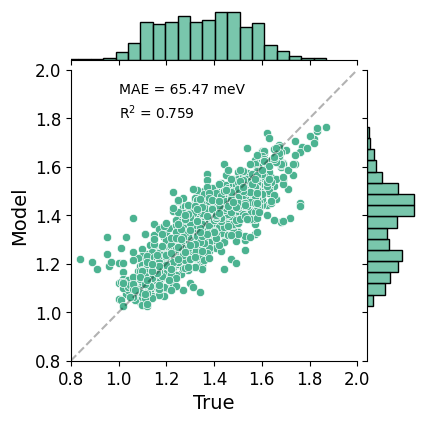

In [16]:
test_plot(t_linear)

## Load pre-trained GBR model and test model on unseen data
The model was built and saved in <font color='blue'>2.MolRedPot_Regression.ipynb</font>

In [7]:
gbr_model = pickle.load(open('Models/EnsembleGBR.sav', 'rb'))
t_gbr=gbr_model.predict(features)

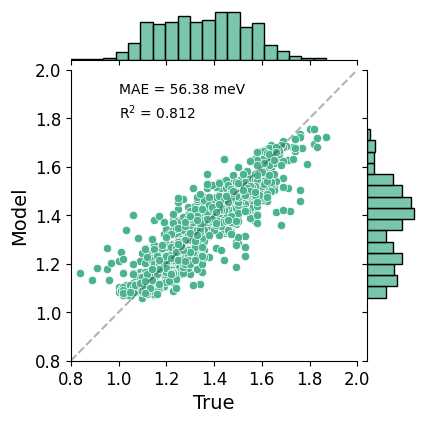

In [8]:
test_plot(t_gbr)

## Load pre-trained NN model and test model on unseen data
The model was built and saved in <font color='blue'>3.MolRedPot_NN.ipynb</font>

In [9]:
NN_model = tf.keras.models.load_model('Models/NN_model_tuned/')
t_NN=NN_model.predict(features)
t_NN=t_NN.flatten()

35/35 [==============================] - 4s 3ms/step


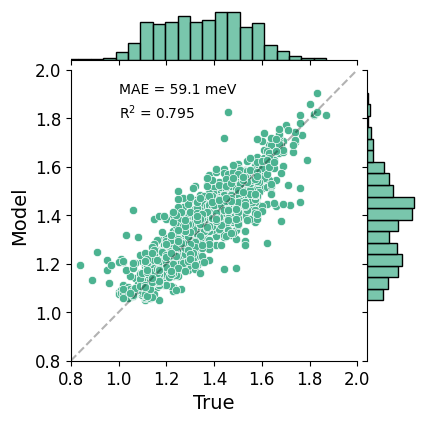

In [17]:
test_plot(t_NN)

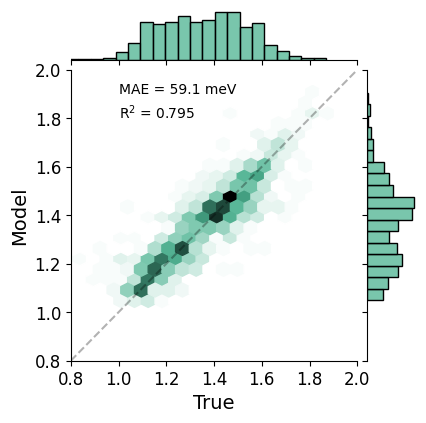

In [19]:
test_plot(t_NN,'hex')

## Final comparison
Use models to predict properties from the training dataset

In [11]:
features_train=pd.read_csv('Data/features_train_scaled.csv')
target_train=pd.read_csv('Data/target_train.csv')['ERed']

In [12]:
print('Feature matrix shape: ',features_train.shape)
print('Target property shape: ',target_train.shape)

Feature matrix shape:  (4353, 32)
Target property shape:  (4353,)


In [13]:
train_linear=lr_model.predict(features_train)
train_gbr=gbr_model.predict(features_train)
train_NN=NN_model.predict(features_train)
train_NN=train_NN.flatten()

137/137 [==============================] - 0s 969us/step


Error metrics using the linear model, for the training and testing datasets

In [14]:
lin_train_mae=np.round(mean_absolute_error(target_train,train_linear),3)*1000
lin_train_r2=np.round(r2_score(target_train,train_linear),3)
lin_test_mae=np.round(mean_absolute_error(target,t_linear),3)*1000
lin_test_r2=np.round(r2_score(target,t_linear),3)

Error metrics using the ensemble model, for the training and testing datasets

In [15]:
gbr_train_mae=np.round(mean_absolute_error(target_train,train_gbr),3)*1000
gbr_train_r2=np.round(r2_score(target_train,train_gbr),3)
gbr_test_mae=np.round(mean_absolute_error(target,t_gbr),3)*1000
gbr_test_r2=np.round(r2_score(target,t_gbr),3)

Error metrics using the NN, for the training and testing datasets

In [16]:
nn_train_mae=np.round(mean_absolute_error(target_train,train_NN),3)*1000
nn_train_r2=np.round(r2_score(target_train,train_NN),3)
nn_test_mae=np.round(mean_absolute_error(target,t_NN),3)*1000
nn_test_r2=np.round(r2_score(target,t_NN),3)

## Organise error metrics into dataframe

In [17]:
df=pd.DataFrame({'Model':['LR','GBR','NN'],
              'Train MAE':[lin_train_mae,gbr_train_mae,nn_train_mae],
              'Train R2':[lin_train_r2,gbr_train_r2,nn_train_r2],
              'Test MAE':[lin_test_mae,gbr_test_mae,nn_test_mae],
              'Test R2':[lin_test_r2,gbr_test_r2,nn_test_r2]})
df

,Model,Train MAE,Train R2,Test MAE,Test R2
0,LR,63.0,0.771,65.0,0.759
1,GBR,47.0,0.866,56.0,0.812
2,NN,50.0,0.840,59.0,0.795


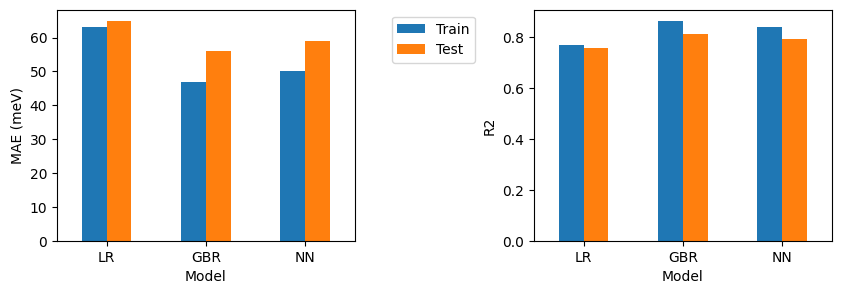

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
df[['Model','Train MAE','Test MAE']].set_index('Model').plot(kind='bar', rot=0,ax=ax1)
ax1.set_ylabel('MAE (meV)')
ax1.legend(['Train','Test'],bbox_to_anchor=(1.1, 1))
df[['Model','Train R2','Test R2']].set_index('Model').plot(kind='bar', rot=0,ax=ax2,legend=None)
ax2.set_ylabel('R2')
plt.subplots_adjust(wspace=0.6)
plt.show()

The gradient boosting regression model has the best performance. 
1. The training and testing MAE values for the reduction potential are both < 50 meV.
2. The training and testing R2 values for the reduction potential are both > 0.8.

## Save predicted reduction potentials using the GBR model

In [19]:
gbr_model = pickle.load(open('Models/EnsembleGBR.sav', 'rb'))

features=pd.read_csv('Data/features_train_scaled.csv')
t_gbr_1=gbr_model.predict(features)


features=pd.read_csv('Data/features_test_scaled.csv')
t_gbr_2=gbr_model.predict(features)

In [20]:
np.savetxt('GBR_predictions.txt',np.round(np.concatenate((t_gbr_1,t_gbr_2)),3))

Finally, a Python+Dash web app is developed in the <font color=blue>dashboard/</font> directory, displaying the predicted reduction potential values using different ML models.